In [2]:
from src import *

## Description

Order the films and rests for an averaged gradients over participants to then order the films and rests videos in some manifold.

GOAL: Ordering metric and observing the relative positions of movies/rest

## Table of Contents

- [All Video Processing](#all)
    - Functional Connectivity Matrix and Gradient Computation
    - Joint Plot 1st and 2nd Gradient
    - Visualization of Gradients on Cortical Surfaces

- [Ordering of Videos](#order)
    - Distance definition 
    - Order of films and observations

In [3]:
mri_path = "./data/fmri_compiled/"
print(os.listdir(mri_path))

movie_name   = os.listdir(mri_path)[14]
nmovie       = movie_name.split('_')[0]
mri_df       = pd.read_csv(mri_path + movie_name)
# mri_df2      = pd.read_csv(mri_path + "Rest_compiled.csv")

['TheSecretNumber_compiled.csv', 'ToClaireFromSonny_compiled.csv', 'Chatter_compiled.csv', 'LessonLearned_compiled.csv', 'Payload_compiled.csv', 'AfterTheRain_compiled.csv', 'Superhero_compiled.csv', 'Sintel_compiled.csv', 'TearsOfSteel_compiled.csv', 'BetweenViewing_compiled.csv', 'BigBuckBunny_compiled.csv', 'Rest_compiled.csv', 'YouAgain_compiled.csv', 'Spaceman_compiled.csv', 'FirstBite_compiled.csv']


<a class="anchor" id="all"></a>
### Group Level

#### NOTE: Group level gradients for each films were aligned to rest gradients group level

Functional Connectivity Matrix and Gradient computation

In [4]:
movies = [m for m in mri_df.filename.unique() if "400" in m]
# rests  = [m for m in mri_df2.filename.unique() if "400" in m]

In [5]:
# trim the washimg time for movies before and after
wash  = 93.9/ TR # duration in seconds for wash is 93.9 sec
onset = 6 / TR # duration of onset is assumed to be 6 sec
film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
duration_film =  int(film_duration/ TR) # in number of TRs
front_pad     = int(wash + onset) + 1

movie_series = []
rest_series  = []
for m in movies:
    tmp1, movie_df = df_to_timeseries(mri_df, m)
    tmp1    = tmp1[front_pad :  front_pad + duration_film]
    movie_series.append(tmp1)
# for r in rests:
#     tmp2, rest_df = df_to_timeseries(mri_df2, r)
#     rest_series.append(tmp2)

In [6]:
movies_series = np.concatenate(movie_series)
# rests_series  = np.concatenate(rest_series)

In [113]:
correlation_measure = ConnectivityMeasure(kind='correlation')


embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

fc_movies = correlation_measure.fit_transform([movies_series])[0]
# fc_rests  = correlation_measure.fit_transform([rests_series])[0]

# g_rests  = GradientMaps(n_components=nb_comp, approach=embedding, 
#                         kernel=aff_kernel, random_state=rs)
# g_rests.fit(fc_rests)

# we fit movies' gradient onto rests'
g_movies = GradientMaps(n_components=nb_comp, approach=embedding, alignment=align_meth,
                        kernel=aff_kernel, random_state=rs)
g_movies.fit(fc_movies, reference=g_rests.gradients_)
print("Alignement score movies on rests': {}".format(procrustes_score(g_rests.gradients_, g_movies.aligned_)))

Alignement score movies on rests': 26.657304306488577


In [114]:
# save('./resources/static_grad/group_level/Rest_group_grad.pkl',g_rests.gradients_)
save('./resources/static_grad/group_level/{}_group_grad.pkl'.format(nmovie),g_movies.aligned_)

Joint Plot of 1st and 2nd Gradient

In [7]:
path  = './resources/static_grad/group_level/'
grads = []
labels = []
for mov in os.listdir(path):
    grads.append(load(path + mov))
    labels.append(mov.split('_')[0])

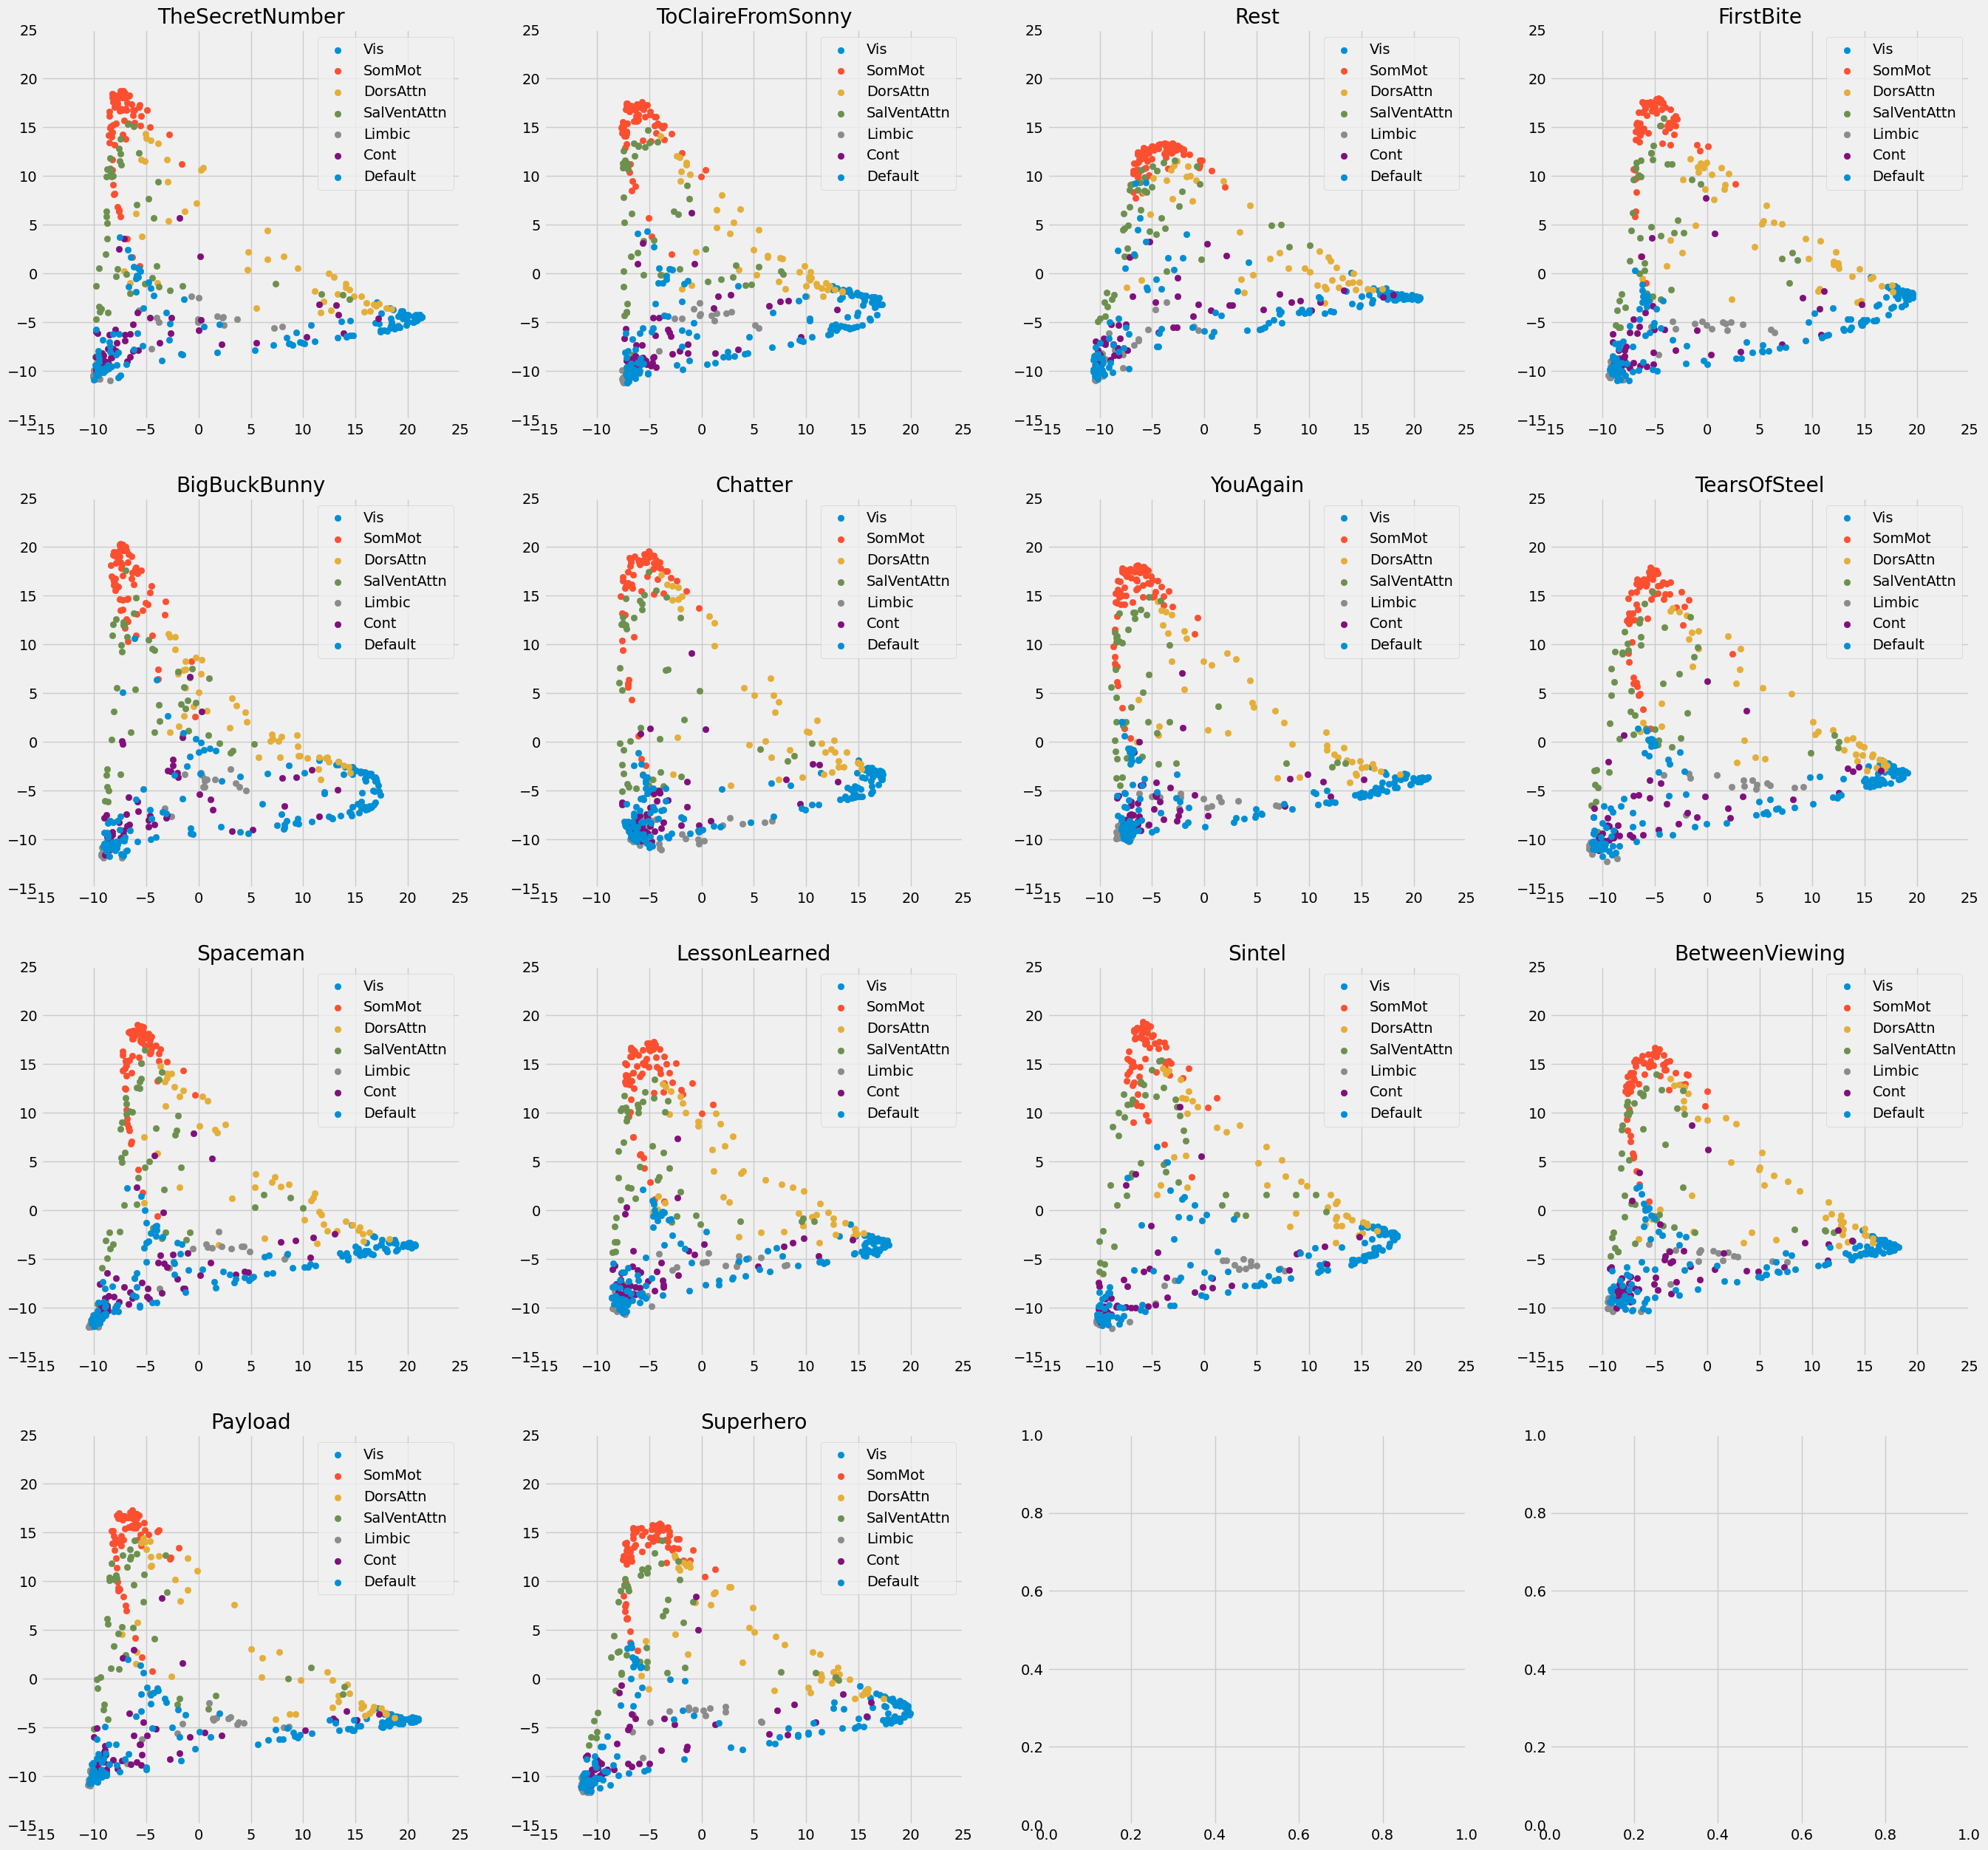

In [13]:
partial_region = load('./resources/yeo7region400.pkl')

fig, ax = plt.subplots(4,4, figsize=(30,30))
for i in range(len(labels)):
    r,c = i//4, i%4
    L = labels[i]
    G = grads[i]

    for k in partial_region:
        
        ax[r,c].scatter(G[partial_region[k],0],G[partial_region[k],1], label=k)

    ax[r,c].set_title(L)
    ax[r,c].set_xlim(-15,25)
    ax[r,c].set_ylim(-15,25)
    ax[r,c].legend()

In [28]:
np.random.seed(16)
twograds = np.asarray(grads)[:,:,[0,1]]
aff_mat  = np.zeros((len(twograds), len(twograds)))
for r,g1 in enumerate(twograds):
    for c,g2 in enumerate(twograds):
        dist = np.sum([points_distance(g1[n],g2[n]) for n in range(len(g1))])
        aff_mat[r,c] = dist

aff_mat = 1 - aff_mat/(aff_mat.max())
aff_mat += np.random.random((14,14))/50

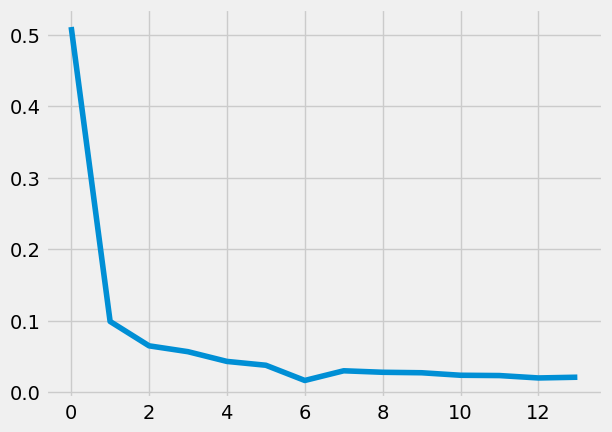

In [29]:
dstr, dspace = np.real(np.linalg.eig(aff_mat)[0]), np.real(np.linalg.eig(aff_mat)[1])
plt.plot(dstr/dstr.sum())

Text(0, 0.5, 'gradient2')

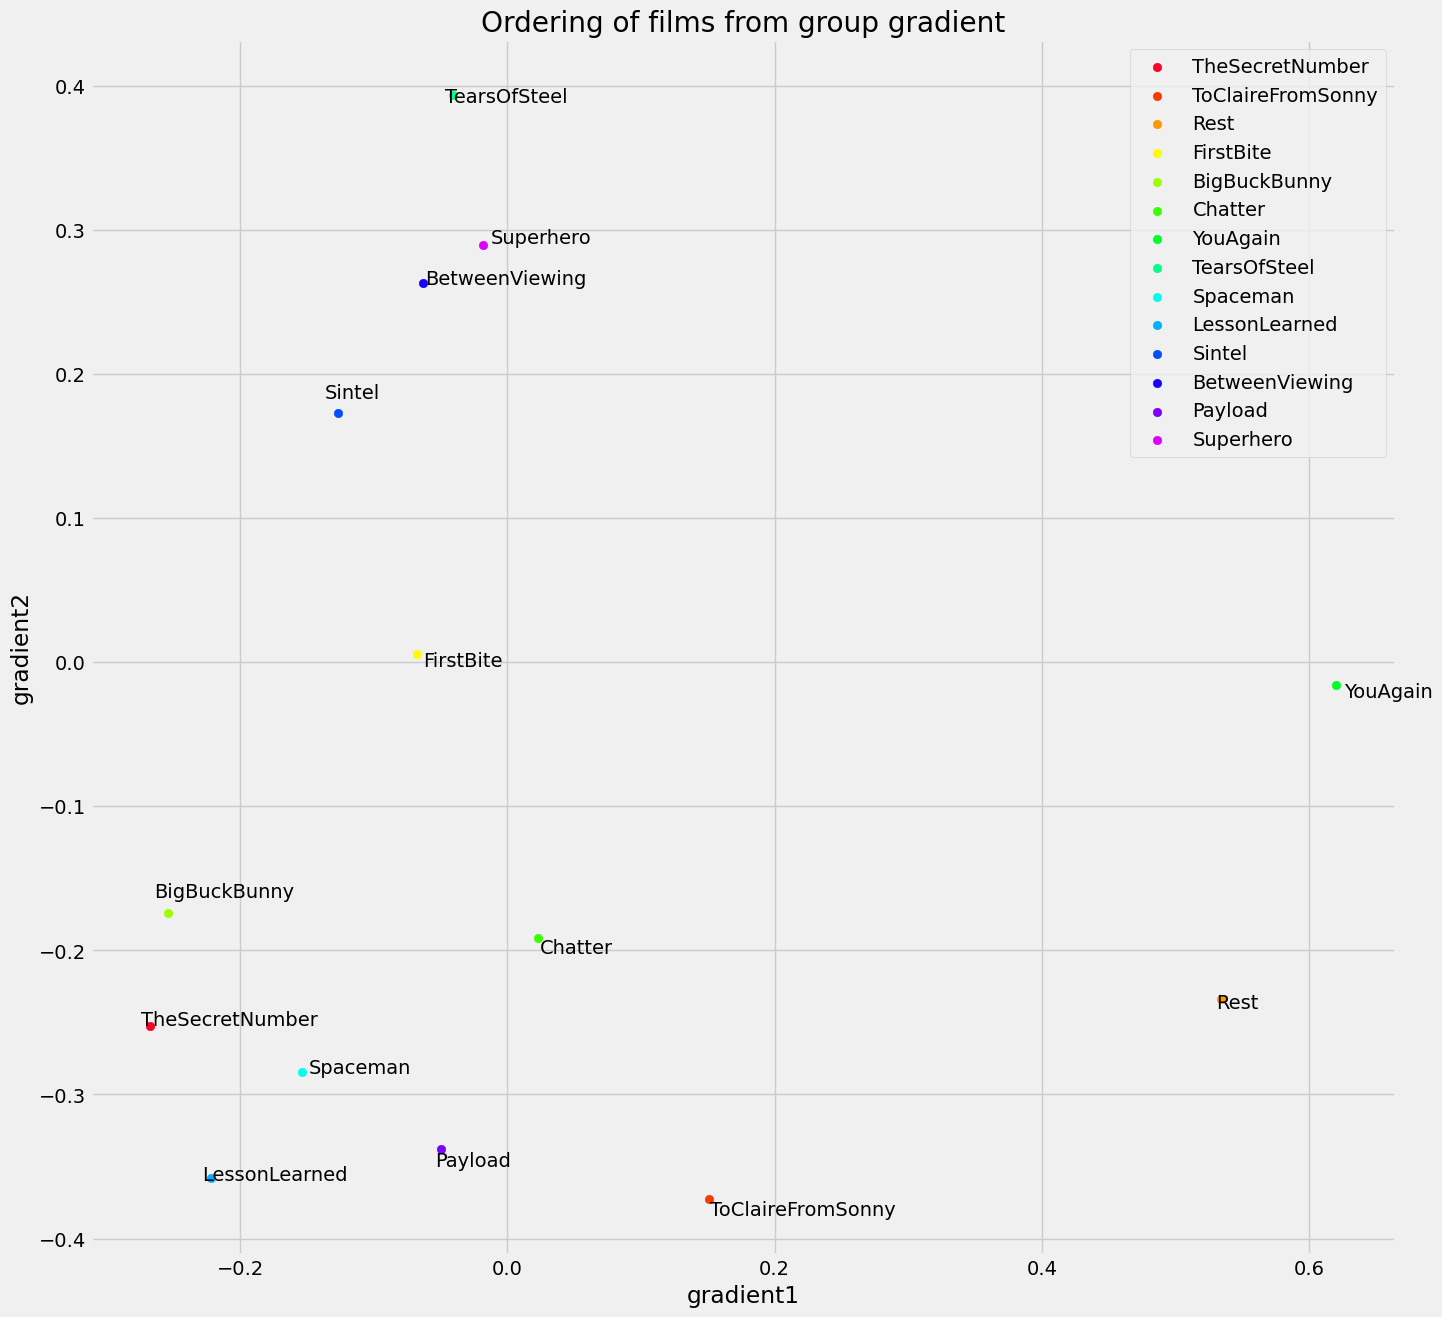

In [30]:
np.random.seed(16)
NUM_COLORS = len(dspace)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
twograds = dspace[[0,1]]

for i, txt in enumerate(labels):
    ax.scatter([twograds[0][i]], [twograds[1][i]], label=txt)
    
    ax.annotate(txt, (twograds[0][i] + (np.random.random()-0.5) / 40,
                     twograds[1][i] + (np.random.random()-0.5) / 40 ) )

ax.set_title("Ordering of films from group gradient")
ax.legend(loc=1)
ax.set_xlabel("gradient1")
ax.set_ylabel("gradient2")